In [2]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
img_size = 96
epochs = 75
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23
print(seed)

data_dir = "KDEFMF/Male"
data_dir1= "KDEFMF/Female"

23


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split=testsplit
)


train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
val_generator1 = train_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)

Found 1198 images belonging to 7 classes.
Found 286 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


In [4]:
from tensorflow.keras.callbacks import *
checkpoint = ModelCheckpoint('MNV2KDEFMalemodel.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

In [5]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


In [6]:
# Check data generators
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")

# Check class indices
print(f"Training class indices: {train_generator.class_indices}")
print(f"Validation class indices: {val_generator.class_indices}")

# Ensure correct optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure ModelCheckpoint is correctly configured
checkpoint = ModelCheckpoint('MNV2KDEFMalemodel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=75,
    callbacks=[checkpoint]
)

Number of training samples: 25
Number of validation samples: 7
Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Epoch 1/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.1491 - loss: 7.4323
Epoch 1: val_accuracy improved from -inf to 0.13851, saving model to MNV2KDEFMalemodel.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.1490 - loss: 7.4301 - val_accuracy: 0.1385 - val_loss: 4.8219
Epoch 2/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.1754 - loss: 7.1291
Epoch 2: val_accuracy did not improve from 0.13851
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 916ms/step - accuracy: 0.1755 - loss: 7.1273 - val_accuracy: 0.1351 - val_loss: 4.9603
Epoch 3/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.2057 - loss: 6.8766
Epoch 3: val_accuracy improved from 0.13851 to 0.15878, saving model to M

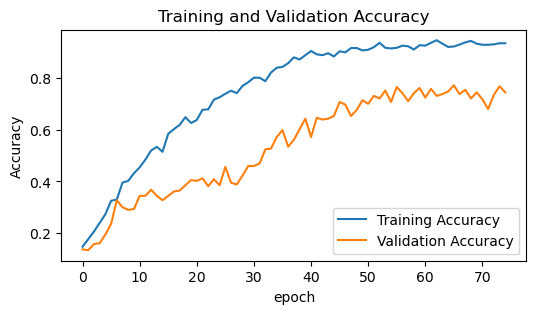

In [7]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

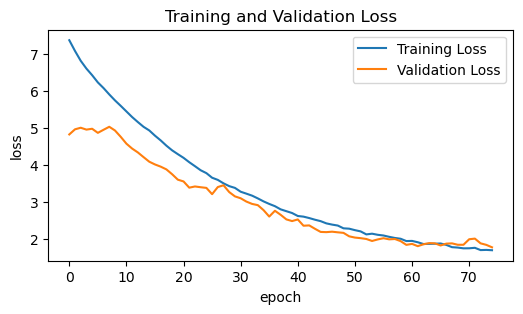

In [8]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step


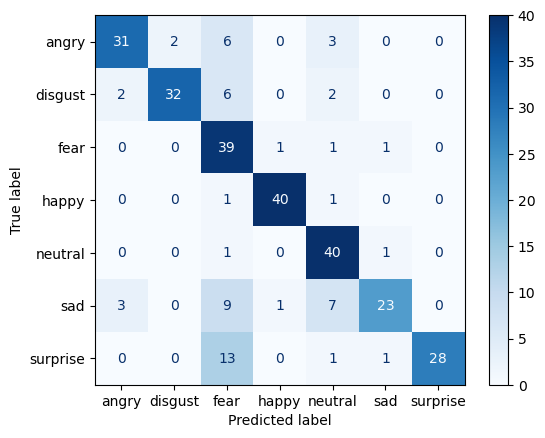

In [5]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [5]:
import tensorflow as tf
model =tf.keras.models.load_model('MNV2KDEFFemalemodel.keras')
predictions1 = model.predict(val_generator1, steps=len(val_generator1))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator1.classes, y_pred=y, target_names=val_generator1.class_indices)
print(cr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.66      0.56      0.61        41
     disgust       0.82      0.80      0.81        41
        fear       0.93      0.33      0.49        42
       happy       0.92      0.83      0.87        41
     neutral       0.73      0.98      0.83        41
         sad       0.60      0.65      0.63        40
    surprise       0.66      1.00      0.79        40

    accuracy                           0.73       286
   macro avg       0.76      0.74      0.72       286
weighted avg       0.76      0.73      0.72       286



In [6]:
import tensorflow as tf
model =tf.keras.models.load_model('MNV2KDEFFemalemodel.keras')
predictions = model.predict(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.55      0.81      0.65        42
     disgust       0.77      0.55      0.64        42
        fear       0.56      0.45      0.50        42
       happy       0.91      0.69      0.78        42
     neutral       0.76      0.52      0.62        42
         sad       0.56      0.65      0.60        43
    surprise       0.68      0.93      0.78        43

    accuracy                           0.66       296
   macro avg       0.68      0.66      0.65       296
weighted avg       0.68      0.66      0.65       296



In [7]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

Y_pred1 = model.predict(val_generator1)
y_pred1 = np.argmax(Y_pred1, axis=1)
y_true1=val_generator1.classes

cm_first = confusion_matrix(y_true, y_pred)

cm_second = confusion_matrix(y_true1, y_pred1)

# Print the confusion matrices
print("Confusion Matrix for First Dataset:")
print(cm_first)

print("Confusion Matrix for Second Dataset:")
print(cm_second)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
Confusion Matrix for First Dataset:
[[32  2  0  2  1  5  0]
 [10 25  2  0  0  5  0]
 [ 3  2 17  0  1  2 17]
 [ 2  0  6 32  0  1  1]
 [ 3  0  2  0 27  7  3]
 [ 3  3  5  0  3 29  0]
 [ 1  0  2  0  1  0 39]]
Confusion Matrix for Second Dataset:
[[22  3  1  0  3 10  2]
 [ 3 34  0  1  0  3  0]
 [ 4  1 14  0  5  3 15]
 [ 1  0  1 33  3  0  3]
 [ 1  0  0  0 37  0  3]
 [ 4  1  1  0  9 24  1]
 [ 0  0  0  0  0  0 40]]


In [8]:
from keras import metrics

accuracy_male = metrics.Accuracy()
accuracy_female = metrics.Accuracy()
accuracy_male.update_state(y_true, y_pred)
accuracy_female.update_state(y_true1, y_pred1)

# Calculate the accuracy results
accuracy_result_male = accuracy_male.result().numpy()
accuracy_result_female = accuracy_female.result().numpy()

# Print the individual accuracies
print("Male Accuracy: %f" % accuracy_result_male)
print("Female Accuracy: %f" % accuracy_result_female)

# Calculate the accuracy difference
accuracy_difference = accuracy_result_male - accuracy_result_female
DP = accuracy_result_female/accuracy_result_male
# Print the accuracy difference
print("Accuracy Difference: %f" % accuracy_difference)
print("DP: %f" % DP)

Male Accuracy: 0.679054
Female Accuracy: 0.713287
Accuracy Difference: -0.034233
DP: 1.050412


In [26]:
import joblib
# Extract and save TP, FP, TN, FN for the first dataset
metrics_first = {}
for i in range(len(cm_first)):
    TP = cm_first[i, i]
    FP = sum(cm_first[:, i]) - TP
    TN = sum(cm_first[j, j] for j in range(len(cm_first)) if j != i)
    FN = sum(cm_first[i, :]) - TP
    metrics_first[i] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

# Extract and save TP, FP, TN, FN for the second dataset
metrics_second = {}
for i in range(len(cm_second)):
    TP = cm_second[i, i]
    FP = sum(cm_second[:, i]) - TP
    TN = sum(cm_second[j, j] for j in range(len(cm_second)) if j != i)
    FN = sum(cm_second[i, :]) - TP
    metrics_second[i] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}

# Save the metrics to files
joblib.dump(metrics_first, 'female_metrics_first.joblib')
joblib.dump(metrics_second, 'female_metrics_second.joblib')

['female_metrics_second.joblib']

In [27]:
# Load the saved metrics
metrics_first = joblib.load('female_metrics_first.joblib')
metrics_second = joblib.load('female_metrics_second.joblib')

# Calculate accuracy for the first dataset
accuracy_first = 0
for class_id in metrics_first.keys():
    TP = metrics_first[class_id]['TP']
    TN = metrics_first[class_id]['TN']
    FP = metrics_first[class_id]['FP']
    FN = metrics_first[class_id]['FN']
    accuracy_first += (TP + TN) / (TP + TN + FP + FN)

accuracy_first /= len(metrics_first)

# Calculate accuracy for the second dataset
accuracy_second = 0
for class_id in metrics_second.keys():
    TP = metrics_second[class_id]['TP']
    TN = metrics_second[class_id]['TN']
    FP = metrics_second[class_id]['FP']
    FN = metrics_second[class_id]['FN']
    accuracy_second += (TP + TN) / (TP + TN + FP + FN)

accuracy_second /= len(metrics_second)

# Calculate the accuracy difference
accuracy_difference = accuracy_first - accuracy_second

# Print the results
print(f"Accuracy for the first dataset: {accuracy_first}")
print(f"Accuracy for the second dataset: {accuracy_second}")
print(f"Accuracy difference: {accuracy_difference}")

Accuracy for the first dataset: 0.8641969570983559
Accuracy for the second dataset: 0.8999956563869981
Accuracy difference: -0.03579869928864221


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion: sad


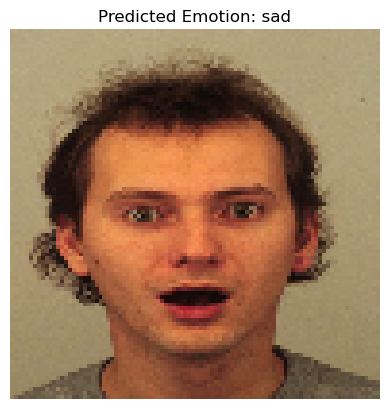

In [11]:
# Ensure you have matplotlib installed, otherwise install it using pip
# pip install matplotlib

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path, target_size=(96,96)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array  # Return both the PIL image and the preprocessed array

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('12_21.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Emotion: sad


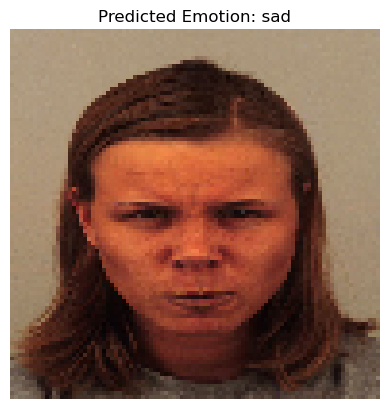

In [12]:
# Ensure you have matplotlib installed, otherwise install it using pip
# pip install matplotlib

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image_path, target_size=(96,96)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array  # Return both the PIL image and the preprocessed array

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('0_29.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot